In [157]:
from astropy.utils.data import get_pkg_data_filename
from astropy.timeseries import TimeSeries

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from astropy.utils.data import get_pkg_data_filename
from astropy.timeseries import TimeSeries

from astropy.time import Time
from lightkurve import search_lightcurvefile, search_lightcurve
from lightkurve import LightCurveCollection
import warnings
from lightkurve.utils import LightkurveWarning


In [158]:
#!pip install lightkurve

In [159]:
example_data = get_pkg_data_filename('timeseries/kplr010666592-2009131110544_slc.fits')

kepler = TimeSeries.read(example_data, format='kepler.fits', unit_parse_strict='silent')

In [160]:
kepler.columns

<TableColumns names=('time','timecorr','cadenceno','sap_flux','sap_flux_err','sap_bkg','sap_bkg_err','pdcsap_flux','pdcsap_flux_err','sap_quality','psf_centr1','psf_centr1_err','psf_centr2','psf_centr2_err','mom_centr1','mom_centr1_err','mom_centr2','mom_centr2_err','pos_corr1','pos_corr2')>

[Text(0.5, 0, 'Julian Date'), Text(0, 0.5, 'SAP Flux (e-/s)')]

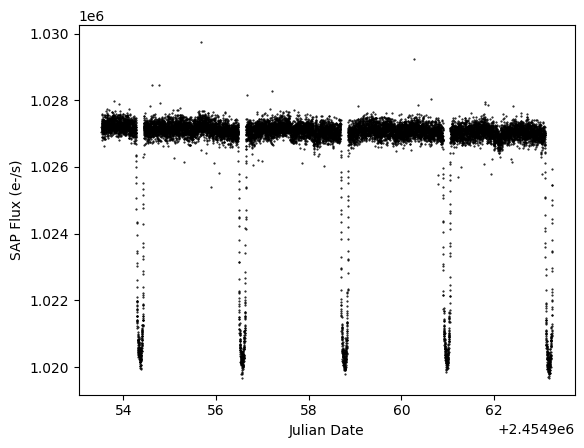

In [161]:

fig, ax = plt.subplots()
ax.plot(kepler.time.jd, kepler['sap_flux'], 'k.', markersize=1)
ax.set(xlabel='Julian Date', ylabel='SAP Flux (e-/s)')

| #  | KIC ID          | Common notes                           |
| -- | --------------- | -------------------------------------- |
| 1  | **KIC 7198959** | **RR Lyr itself** (prototype, Blazhko) |
| 2  | **KIC 3733346** | RRab, non-Blazhko                      |
| 3  | **KIC 3864443** | RRab                                   |
| 4  | **KIC 4484128** | RRab                                   |
| 5  | **KIC 5559631** | RRab                                   |
| 6  | **KIC 6186029** | RRab                                   |
| 7  | **KIC 6763132** | RRab                                   |
| 8  | **KIC 7030715** | RRab                                   |
| 9  | **KIC 7257008** | RRab                                   |
| 10 | **KIC 9973633** | RRab                                   |


In [162]:
kic_ids = [
    "KIC 7198959",
    "KIC 3733346",
    "KIC 3864443",
    "KIC 4484128",
    "KIC 5559631",
    "KIC 6186029",
    "KIC 6763132",
    "KIC 7030715",
    "KIC 7257008",
    "KIC 9973633"
]

print(kic_ids)

['KIC 7198959', 'KIC 3733346', 'KIC 3864443', 'KIC 4484128', 'KIC 5559631', 'KIC 6186029', 'KIC 6763132', 'KIC 7030715', 'KIC 7257008', 'KIC 9973633']


In [163]:
def kepler_to_ogle_dat(
    target="KIC 3733346",
    cadence="long",
    out_path=None,
    sigma_clip=8,
    include_mag_err=True,
    time_format="JD"  # "JD" is simplest; OGLE often uses HJD—see note below
):
    # --- Download Kepler LC ---
    sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
    lcf = sr.download()
    lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)

    # --- Time: BKJD -> JD (TDB) ---
    t_bkjd = lc.time.value
    t_jd = Time(t_bkjd + 2454833.0, format="jd", scale="tdb").jd

    # --- Flux -> relative magnitude ---
    flux = lc.flux.value
    f0 = np.nanmedian(flux)
    mag = -2.5 * np.log10(flux / f0)

    # --- Optional magnitude error propagation ---
    # If flux_err exists, propagate: sigma_m = (2.5/ln(10)) * (sigma_F / F)
    if include_mag_err and hasattr(lc, "flux_err") and lc.flux_err is not None:
        flux_err = lc.flux_err.value
        mag_err = (2.5 / np.log(10)) * (flux_err / flux)
    else:
        mag_err = None

    # --- Sort by time (OGLE files are often sorted) ---
    idx = np.argsort(t_jd)
    t_jd = t_jd[idx]
    mag = mag[idx]
    if mag_err is not None:
        mag_err = mag_err[idx]

    # --- Output path ---
    if out_path is None:
        out_path = f"{target.replace(' ', '_')}_KEPLER_OGLELIKE.dat"

    # --- Save ---
    header = f"# {target} Kepler PDCSAP converted to OGLE-like format\n# columns: {time_format}  mag" + (  "" if mag_err is None else "  mag_err")
    if mag_err is None:
        arr = np.column_stack([t_jd, mag])
        np.savetxt(out_path, np.asarray(arr), fmt="%.8f %.6f", header=header)
    else:
        arr = np.column_stack([t_jd, mag, mag_err])
        np.savetxt(out_path, np.asarray(arr), fmt="%.8f %.6f %.6f", header=header)

    return out_path


In [164]:

# Example
for lc in kic_ids:
  path = kepler_to_ogle_dat(target=lc, cadence="long", include_mag_err=True)
  print("Saved:", path)

/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)
/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lig

Saved: KIC_7198959_KEPLER_OGLELIKE.dat


/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)
/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 14 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Saved: KIC_3733346_KEPLER_OGLELIKE.dat


/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)
/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 14 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Saved: KIC_3864443_KEPLER_OGLELIKE.dat


/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)
/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 17 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_cl

Saved: KIC_4484128_KEPLER_OGLELIKE.dat
Saved: KIC_5559631_KEPLER_OGLELIKE.dat


/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 13 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)
/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_li

Saved: KIC_6186029_KEPLER_OGLELIKE.dat
Saved: KIC_6763132_KEPLER_OGLELIKE.dat


/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)
/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 18 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_cl

Saved: KIC_7030715_KEPLER_OGLELIKE.dat
Saved: KIC_7257008_KEPLER_OGLELIKE.dat
Saved: KIC_9973633_KEPLER_OGLELIKE.dat


/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)
/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_cli

/tmp/ipython-input-1875699483.py:6: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence="long")
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 17 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipython-input-1875699483.py:8: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=8)


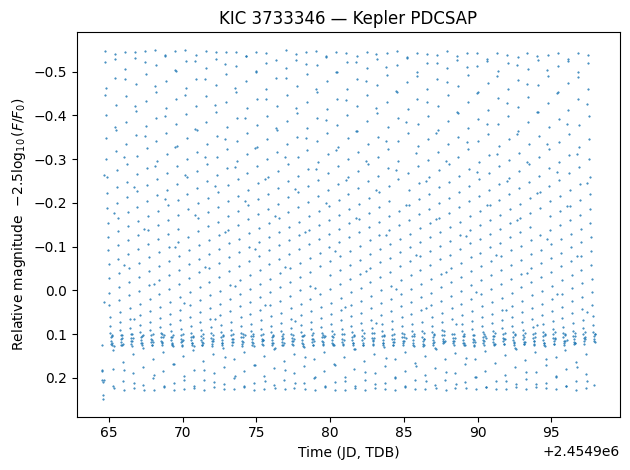

In [165]:

# ---- 1) Search and download a Kepler light curve ----
# Options: "KIC 757076", "Kepler-10", etc.
target = "KIC 3733346"

# Kepler long cadence example; you can also try cadence="short"
sr = search_lightcurvefile(target, mission="Kepler", cadence="long")
lcf = sr.download()  # downloads one product (typically the "best" match)
lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=8)

# ---- 2) Convert time to Astropy Time (optional but nice) ----
# Kepler times are usually in BKJD = BJD - 2454833
t_bkjd = lc.time.value
t = Time(t_bkjd + 2454833.0, format="jd", scale="tdb")  # now it's true JD time

# ---- 3) Flux -> magnitude (relative) ----
# Use a reference flux so you get relative magnitudes (no absolute zeropoint needed)
flux = lc.flux.value
f0 = np.nanmedian(flux)
mag = -2.5 * np.log10(flux / f0)

# ---- 4) Plot ----
plt.figure()
plt.plot(t.jd, mag, ".", markersize=1)
plt.gca().invert_yaxis()  # magnitudes: smaller = brighter
plt.xlabel("Time (JD, TDB)")
plt.ylabel(r"Relative magnitude  $-2.5\log_{10}(F/F_0)$")
plt.title(f"{target} — Kepler PDCSAP")
plt.tight_layout()
plt.show()


In [166]:
print("\n--- Processing a single KIC ID with updated function---\n")
single_target_id = "KIC 7198959"
path_single = kepler_to_ogle_dat(target=single_target_id, cadence="long", include_mag_err=True)
print(f"Saved single target data to: {path_single}")


--- Processing a single KIC ID with updated function---

Saved single target data to: KIC_7198959_KEPLER_OGLELIKE.dat


/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)


In [167]:
print("\n--- Processing multiple KIC IDs with updated function---\n")
for lc in kic_ids:
  path = kepler_to_ogle_dat(target=lc, cadence="long", include_mag_err=True)
  print(f"Saved: {path}")


--- Processing multiple KIC IDs with updated function---



/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)


Saved: KIC_7198959_KEPLER_OGLELIKE.dat


/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 17 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)


Saved: KIC_3733346_KEPLER_OGLELIKE.dat


/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 14 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Saved: KIC_3864443_KEPLER_OGLELIKE.dat


/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)
/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 14 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_cl

Saved: KIC_4484128_KEPLER_OGLELIKE.dat


/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)
/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 13 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_cl

Saved: KIC_5559631_KEPLER_OGLELIKE.dat
Saved: KIC_6186029_KEPLER_OGLELIKE.dat


/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)
/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 18 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_cl

Saved: KIC_6763132_KEPLER_OGLELIKE.dat
Saved: KIC_7030715_KEPLER_OGLELIKE.dat
Saved: KIC_7257008_KEPLER_OGLELIKE.dat
Saved: KIC_9973633_KEPLER_OGLELIKE.dat


/tmp/ipython-input-1183929390.py:10: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(target, mission="Kepler", cadence=cadence)
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipython-input-1183929390.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans().remove_outliers(sigma=sigma_clip)


In [168]:


import numpy as np
import warnings
from astropy.time import Time

from lightkurve import search_lightcurvefile
from lightkurve.collections import LightCurveCollection
from lightkurve.utils import LightkurveWarning

def _pick_flux_from_lcf(lcf, prefer_pdcsap=True):
    """
    Return a LightCurve object and label, choosing the best available flux type.
    Works even when PDCSAP is missing.
    """
    # Most common case
    if prefer_pdcsap and hasattr(lcf, "PDCSAP_FLUX"):
        return lcf.PDCSAP_FLUX, "PDCSAP_FLUX"
    if hasattr(lcf, "SAP_FLUX"):
        return lcf.SAP_FLUX, "SAP_FLUX"

    # Fallback: inspect columns and try known variants
    # (Some products expose different column naming conventions)
    cols = []
    try:
        cols = [c.lower() for c in lcf.hdu[1].columns.names]
    except Exception:
        pass

    # Try common alternatives
    for cand in ["pdcsap_flux", "sap_flux", "flux"]:
        if cand in cols:
            # Build a LightCurve from that column using Lightkurve's to_lightcurve if available
            try:
                lc = lcf.get_lightcurve(flux_column=cand.upper())
                return lc, cand.upper()
            except Exception:
                # If get_lightcurve isn't present, we just fall through
                pass

    raise KeyError(
        "No usable flux column found in this LightCurveFile. "
        "Try another cadence/sector/product or inspect lcf.hdu[1].columns.names."
    )

def space_mission_to_ogle_dat(
    target="KIC 3733346",
    mission="Kepler",
    cadence="long",
    out_path=None,
    sigma_clip=8,
    include_mag_err=True,
    prefer_pdcsap=True,
    time_mode="auto",   # "auto" or "force_offset"
):
    mission = mission.strip()
    if mission not in {"Kepler", "TESS"}:
        raise ValueError("mission must be 'Kepler' or 'TESS'.")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", LightkurveWarning)

        sr = search_lightcurvefile(target, mission=mission, cadence=cadence)
        lcf_coll = sr.download_all()

        if lcf_coll is None or len(lcf_coll) == 0:
            print(f"Warning: No LC found for {target} (mission={mission}, cadence={cadence}).")
            return None

        # Collect LightCurves (one per file), selecting best available flux for each
        lcs = []
        chosen_labels = []
        for lcf in lcf_coll:
            lc_i, label_i = _pick_flux_from_lcf(lcf, prefer_pdcsap=prefer_pdcsap)
            lcs.append(lc_i)
            chosen_labels.append(label_i)

        # Stitch
        lc = LightCurveCollection(lcs).stitch().remove_nans().remove_outliers(sigma=sigma_clip)

        # Time offset per mission
        offset = 2454833.0 if mission == "Kepler" else 2457000.0

        # Extract arrays as plain numpy
        t_raw = np.asarray(lc.time.value)
        flux = np.asarray(lc.flux.value)

        # Time conversion
        if time_mode == "force_offset":
            t_jd = Time(t_raw + offset, format="jd", scale="tdb").jd
        elif time_mode == "auto":
            if np.nanmedian(t_raw) < 1e5:
                t_jd = Time(t_raw + offset, format="jd", scale="tdb").jd
            else:
                t_jd = Time(t_raw, format="jd", scale="tdb").jd
        else:
            raise ValueError("time_mode must be 'auto' or 'force_offset'.")

        # Flux -> differential magnitude (clip non-positive)
        finite = np.isfinite(flux)
        pos = finite & (flux > 0)
        if not np.any(pos):
            raise ValueError("All flux values are non-positive or non-finite after cleaning.")
        min_pos = np.nanmin(flux[pos])
        flux = np.where((~pos), min_pos, flux)

        f0 = np.nanmedian(flux)
        mag = -2.5 * np.log10(flux / f0)

        # Magnitude errors (if available)
        mag_err = None
        if include_mag_err and getattr(lc, "flux_err", None) is not None:
            flux_err = np.asarray(lc.flux_err.value)
            flux_err = np.where((~np.isfinite(flux_err)) | (flux_err <= 0), np.nan, flux_err)
            mag_err = (2.5 / np.log(10)) * (flux_err / flux)

        # Sort by time
        idx = np.argsort(t_jd)
        t_jd = t_jd[idx]
        mag = mag[idx]
        if mag_err is not None:
            mag_err = mag_err[idx]

        # Output path
        # If mixed labels across sectors, just note "MIXED"
        flux_label = chosen_labels[0] if all(l == chosen_labels[0] for l in chosen_labels) else "MIXED_FLUX"
        if out_path is None:
            out_path = f"{target.replace(' ', '_')}_{mission.upper()}_{flux_label}_OGLELIKE.dat"

        header = (
            f"# {target} {mission} {flux_label} converted to OGLE-like format\n"
            "# columns: JD  mag" + ("" if mag_err is None else "  mag_err")
        )

        if mag_err is None:
            arr = np.column_stack((t_jd, mag))
            np.savetxt(out_path, arr, fmt="%.8f %.6f", header=header)
        else:
            arr = np.column_stack((t_jd, mag, mag_err))
            np.savetxt(out_path, arr, fmt="%.8f %.6f %.6f", header=header)

        print(f"[OK] Used flux column: {flux_label}")
        return out_path


In [ ]:
tic_ids = [
    "TIC 356088697",  # RR Lyr (prototype)
    "TIC 441224134",  # X Ari
    "TIC 139876329",  # UV Oct
    "TIC 260795086",  # RZ Cep
    "TIC 394155545",  # SU Dra
    "TIC 41234571",   # XZ Cyg
    "TIC 275500946",  # DM Cyg
    "TIC 233547261",  # SS For
    "TIC 466241076",  # RV Oct
    "TIC 140900432"   # BH Aur
]

In [171]:
path_tess_valid = space_mission_to_ogle_dat(target="TIC 139876329", mission="TESS", cadence="long", include_mag_err=True)

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))